In [20]:
import pandas as pd
import numpy as np
import langid
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
%matplotlib inline

import spacy
# $ python -m spacy download en_core_web_lg

from sklearn.cluster import KMeans

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gdcma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
discourse = pd.read_csv("../data/web.csv", index_col="Unnamed: 0")

In [37]:
discourse.sample(10)

,lat,long,comment,id_web,Country Name,Country Code
70111,30.408066,-87.212817,"A place where I learned to like myself\nand, m...",73989,United States of America,USA
30772,49.257307,-123.247976,"You were the 1st girl I ever kissed, when it h...",32722,Canada,CAN
147163,41.734168,-88.269581,I was in an online relationship w someone quee...,637034,United States of America,USA
42617,42.337611,-71.096960,you took me to the museum of fine arts. we thu...,45544,United States of America,USA
67355,30.259372,-97.738284,This is where we went on our second date. We ...,71150,United States of America,USA
102269,41.861905,-83.986375,Am ace and grew up in this house,108667,United States of America,USA
48135,61.195380,-149.908713,I fell in love with two people and they loved ...,51383,United States of America,USA
120072,44.226557,-69.066664,"stayed in a cute air b&b here once, spent year...",129579,United States of America,USA
84186,38.761609,-75.100471,My girlfriend and I kissed here on top of the ...,89288,United States of America,USA
17317,47.191136,-1.562866,I explained my queerness to you\nyou wanted me...,17818,France,FRA


# Languages discussion

**First try:**
- Langauge detection with `from langdetect import detect`
- Language traduction with `from googletrans import Translator`
The detection was fairly good for comments in english, if they weren't small.
The traduction was limited to only a certain amount of comments.

**Second try:**
- Language detection with `import langid`
- Language traduction with `import deepl`

**Conclusion:**
- No detection and traduction, sentiment analysis a bit biased by english speaking users.
- Add the number of characters as another characteristic to describe intensity of the discourse.
- For those with both of these metrics, see how they relate, and if I could use them together in another metric

**CODE:**

With langdetect library:
```
from langdetect import detect

def detect_language(text):
    return detect(text)
discourse["language"] = discourse["comment"].apply(detect_language)
# This library stopped working for shorter text, maybe because of the version.
```
With langid library:

```
import langid

def detect_language(text):
    return langid.classify(text)[0]
discourse["language_langid"] = discourse["comment"].apply(detect_language)
```
Conclusion:
```
discourse.loc[discourse[(discourse["language"]!= discourse["language_langid"])].index].sample(50)
```
Many differences, and many wrong detections.

To detect **entities**, I have to use only english text. So I would use only those comments detected as english **by both libraries**.

Also if in the end I want to create a **text generator**.

In [38]:
'''from langdetect import detect

def detect_language(text):
    if len(text.split()) >= 5:    # issues when the text is too small
        return detect(text)
    else:
        return "en"
discourse["language"] = discourse["comment"].apply(detect_language)
'''
# No hay manera. I keep increasing the lenght and it keeps giving the same error "No features in text"

'from langdetect import detect\n\ndef detect_language(text):\n    if len(text.split()) >= 5:    # issues when the text is too small\n        return detect(text)\n    else:\n        return "en"\ndiscourse["language"] = discourse["comment"].apply(detect_language)\n'

In [39]:
def detect_language(text):
    return langid.classify(text)[0]
discourse["language_langid"] = discourse["comment"].apply(detect_language)

In [40]:
discourse["language_langid"].loc[discourse[(discourse["language_langid"]!= "en")].index]

48        es
67        fr
69        fr
85        es
261       la
          ..
149519    it
149524    es
149549    ar
149558    sl
149559    el
Name: language_langid, Length: 6841, dtype: object

# Ignore comments with only one word

In [41]:
def keep_sentences(x):
    if " " not in x:
        return float('nan')
    else:
        return x
discourse["comment"] = discourse.comment.apply(keep_sentences)
discourse.dropna(subset="comment", inplace=True)

# Sentiment description

In [42]:
discourse.isna().sum()

lat                   0
long                  0
comment               0
id_web                0
Country Name       7839
Country Code       7839
language_langid       0
dtype: int64

In [43]:
sia = SentimentIntensityAnalyzer()

In [44]:
def sentiment (x):
    try:
        return sia.polarity_scores(x)["compound"]
    except:
        return float('nan')

In [45]:
discourse["sentiment"] = discourse["comment"].apply(sentiment)

In [46]:
discourse.sample()

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment
82280,52.62845,1.303389,told my best friend I was bi,87043,United Kingdom,GBR,en,0.8126


In [49]:
def type_sentiment(x):
    if x < 0:
        return 1
    elif x == 0:
        return 2
    else:
        return 3

In [50]:
discourse["type_sentiment"] = discourse["sentiment"].apply(type_sentiment)

In [51]:
discourse.sample()

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment
48348,40.017885,-105.279821,My first girlfriend kissed me for the second t...,51598,United States of America,USA,en,-0.4451,1


In [52]:
discourse["sentiment"][discourse["sentiment"] == 0].shape

(25048,)

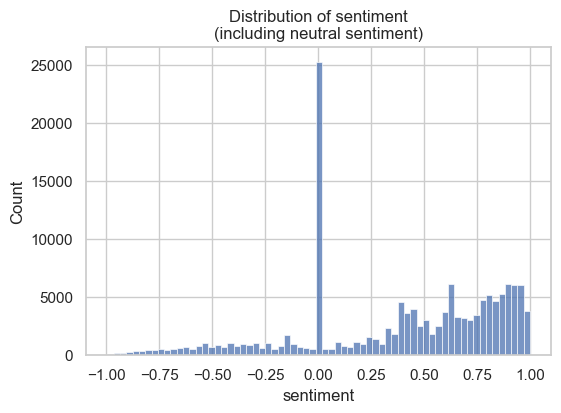

In [53]:
plt.figure(figsize=(6, 4))
sns.histplot(discourse["sentiment"])
plt.title("Distribution of sentiment\n(including neutral sentiment)");

In [54]:
discourse["sentiment"][discourse["sentiment"] != 0].shape

(123682,)

# Lenght analysis

In [59]:
def number_char(text):
    return len(text)
discourse["characters"] = discourse["comment"].apply(number_char)

In [62]:
discourse["characters"].describe()

count    148730.000000
mean        159.401392
std         167.346826
min           3.000000
25%          61.000000
50%         115.000000
75%         202.000000
max        5667.000000
Name: characters, dtype: float64

In [61]:
discourse.loc[discourse["characters"][discourse["characters"] == discourse["characters"].max()].index]

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters
109025,41.690136,-86.858436,I came out in 6th grade I was 13 I came out t...,115674,United States of America,USA,en,0.9937,3,5667


In [63]:
discourse.loc[discourse["characters"][discourse["characters"] == discourse["characters"].min()].index] # one smily

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters
3751,51.496676,-0.210382,:),3759,United Kingdom,GBR,en,0.4588,3,3


In [64]:
discourse = discourse.loc[(discourse["characters"] != discourse["characters"].min())]

In [65]:
discourse.loc[discourse["characters"][discourse["characters"] == discourse["characters"].min()].index]
# Even thou they are positive, and full of pride, these comments don't add anything to the total

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters
32273,34.014454,-117.319785,I am,34312,United States of America,USA,en,0.0,2,4
116641,45.472642,-73.746889,I am,123799,Canada,CAN,en,0.0,2,4
144222,47.670036,-122.305489,🥤 ♥️,505048,United States of America,USA,zh,0.0,2,4


In [68]:
discourse = discourse.loc[(discourse["characters"] != discourse["characters"].min())]
discourse.loc[discourse["characters"][discourse["characters"] == discourse["characters"].min()].index]

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters
83167,33.580964,-117.612333,jc :(,88174,United States of America,USA,en,-0.4404,1,5
93893,56.539253,27.739170,bi :),99542,Latvia,LVA,en,0.4588,3,5
102356,49.164950,-131.083118,y e s,108754,NaN,NaN,it,0.0000,2,5
104880,-46.979142,38.242201,Uh oh,111351,NaN,NaN,de,0.0000,2,5
114146,50.833800,2.880968,im bi,121097,Belgium,BEL,de,0.0000,2,5
119841,-27.494358,153.012101,gay 😌,129132,Australia,AUS,ja,0.0000,2,5
124630,-89.179347,-25.089567,hi :),186603,Antarctica,ATA,it,0.4588,3,5
125110,52.773206,-1.215008,You x,190929,United Kingdom,GBR,en,0.0000,2,5
126118,18.496684,73.865191,you ♡,194822,India,IND,zh,0.0000,2,5
137946,51.213863,4.400321,You 🦁,401524,Belgium,BEL,bn,0.0000,2,5


In [69]:
discourse = discourse.loc[(discourse["characters"] != discourse["characters"].min())]
discourse.loc[discourse["characters"][discourse["characters"] == discourse["characters"].min()].index]

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters
411,49.074766,-123.013229,Saige,412,Canada,CAN,da,0.0000,2,6
20967,38.668637,-7.825341,Bi Gal,21755,Portugal,PRT,en,0.0000,2,6
27661,-37.813523,145.225692,M+J <3,28995,Australia,AUS,en,0.4404,3,6
27662,-37.352713,144.734253,M+J <3,28996,Australia,AUS,en,0.4404,3,6
29040,32.646692,-117.152171,-> !!!,30510,United States of America,USA,en,0.0000,2,6
29159,40.863736,-73.425108,me Gay,30640,United States of America,USA,en,0.0000,2,6
31839,6.167881,-75.577165,Gay af,33844,Colombia,COL,en,0.0000,2,6
31841,6.167881,-75.577165,Gay af,33846,Colombia,COL,en,0.0000,2,6
36694,53.754573,-2.532610,me too,39045,United Kingdom,GBR,en,0.0000,2,6
38289,42.361612,-71.017531,^ same,40742,United States of America,USA,en,0.0000,2,6


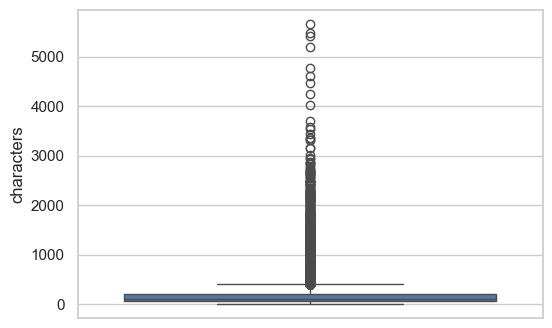

In [70]:
plt.figure(figsize=(6, 4))
sns.boxplot(discourse["characters"]);

In [71]:
discourse["characters"].describe()

count    148715.000000
mean        159.416999
std         167.348049
min           6.000000
25%          61.000000
50%         115.000000
75%         202.000000
max        5667.000000
Name: characters, dtype: float64

In [72]:
Q1_char = discourse["characters"].quantile(0.25)
Q3_char = discourse["characters"].quantile(0.75)
IQR = Q3_char - Q1_char
outlier_sup_char = Q3_char + 1.5 * IQR
outlier_sup_char

413.5

In [73]:
discourse["characters"][discourse["characters"]>outlier_sup_char].shape

(8392,)

# Compound metric of sentiment and lenght
**Key aspects**:
- Longer text imply more emotionality
- Sentiment compound of 0 because the language or because of the own limitations of the nktl library.

**Solution**:
```
length_standard = num_words / nu
emotionality = sentiment * length_standard
```
This has an issue with those false sentiment = 0.
- Turn all the sentiment compounds to their abs value
- To avoid having 0 sentiment, I add 1 to all the sentiment compound

In [76]:
def get_emotionality():
    max_length = discourse["characters"].max()
    length_standard = [(rows["characters"] / max_length) for index, rows in discourse.iterrows()]
    emotionality = ((abs(discourse["sentiment"])) + 1) * length_standard
    return emotionality

In [77]:
discourse["emotionality"] = get_emotionality()

In [78]:
discourse.sample()

,lat,long,comment,id_web,Country Name,Country Code,language_langid,sentiment,type_sentiment,characters,emotionality
137657,44.513368,20.293683,There was my childhood house i was happiest th...,401193,Serbia,SRB,en,0.3003,3,169,0.038777


In [79]:
discourse["emotionality"].describe()

count    148715.000000
mean          0.046012
std           0.056199
min           0.001059
25%           0.014293
50%           0.030142
75%           0.057964
max           1.993700
Name: emotionality, dtype: float64

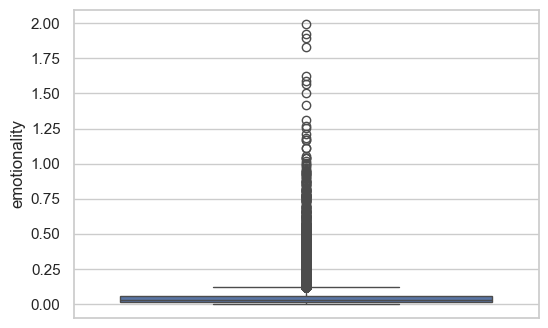

In [80]:
plt.figure(figsize=(6, 4))
sns.boxplot(discourse["emotionality"]);

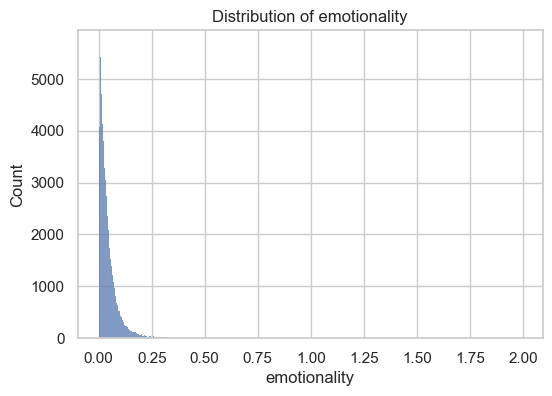

In [81]:
plt.figure(figsize=(6, 4))
sns.histplot(discourse["emotionality"])
plt.title("Distribution of emotionality");

# Country Analysis

In [6]:
countries = list(set(discourse["Country Code"])) 
# print(countries) # To be able to see all the codes

In [86]:
discourse.loc[discourse[discourse["Country Code"]=="-99"].index, "Country Code"] = "XXK"

In [48]:
top_countries = pd.DataFrame(discourse["Country Code"].value_counts().head(10))
top_countries

,count
country_code,
USA,69804
GBR,13134
CAN,12592
AUS,7132
DEU,3680
FRA,3490
ITA,1696
POL,1581
RUS,1323


# Entity analysis
The load of comments (globally, but also nationally) is too big to interpret the entities

# Save discourse and features

In [90]:
features = pd.read_csv("../data/charactCountry/country_features.csv", index_col="Unnamed: 0")

In [91]:
features.sample(5)

,Country Code,mean_stability,mean_law,mean_female_seats,mean_voice,mean_gdp,mean_children_out,mean_ed_exp,mean_literacy,mean_ARV_coverage,mean_health_exp,mean_UHC_coverage,Region,IncomeGroup,Country Name,mean_rights,mean_sex_index,censor,transition,mean_hate_protection
213,YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Middle East & North Africa,Low income,"Yemen, Rep.",NaN,NaN,07. Imprisonment as punishment,NaN,NaN
153,PHL,58.600000,66.722822,44.152047,83.914986,6.379114e+10,4.449132,6.697700,98.040001,58.600000,7.351932,81.333333,East Asia & Pacific,Lower middle income,Philippines,3.071877,0.000000,01. No censorship,04. Ambiguous,0.000000
189,TGO,44.581818,68.459119,15.612648,75.268602,8.881716e+08,7.397477,5.355703,94.388381,44.581818,4.369457,73.666667,Sub-Saharan Africa,Low income,Togo,1.422789,0.111884,01. No censorship,04. Ambiguous,0.058824
209,VNM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,East Asia & Pacific,Lower middle income,Viet Nam,NaN,NaN,01. No censorship,"02. Legal, but requires surgery",NaN
75,GNQ,74.200000,34.558251,10.822151,40.125461,1.712184e+10,27.613962,5.362602,34.499711,74.200000,5.777349,38.666667,Sub-Saharan Africa,Upper middle income,Equatorial Guinea,1.071877,0.000000,01. No censorship,05. Illegal,0.000000


In [92]:
features.shape, discourse.shape

((217, 20), (148715, 11))

In [97]:
df = discourse.merge(features, how="left", on= "Country Code")

In [98]:
df.shape, df.columns

((148715, 30),
 Index(['lat', 'long', 'comment', 'id_web', 'Country Name_x', 'Country Code',
        'language_langid', 'sentiment', 'type_sentiment', 'characters',
        'emotionality', 'mean_stability', 'mean_law', 'mean_female_seats',
        'mean_voice', 'mean_gdp', 'mean_children_out', 'mean_ed_exp',
        'mean_literacy', 'mean_ARV_coverage', 'mean_health_exp',
        'mean_UHC_coverage', 'Region', 'IncomeGroup', 'Country Name_y',
        'mean_rights', 'mean_sex_index', 'censor', 'transition',
        'mean_hate_protection'],
       dtype='object'))

In [99]:
df = df[["id_web", "lat", "long", "comment", "language_langid", "sentiment", "type_sentiment", "characters", "emotionality", 
        'Country Name_x', 'Country Code', 'Region', 'IncomeGroup','mean_stability', 'mean_law', 'mean_female_seats',
        'mean_voice', 'mean_gdp', 'mean_children_out', 'mean_ed_exp', 'mean_literacy', 'mean_ARV_coverage', 'mean_health_exp',
        'mean_UHC_coverage', 'mean_rights', 'mean_sex_index', 'censor', 'transition', 'mean_hate_protection']]

In [100]:
df.rename(columns={"language_langid": "language", "Country Name_x": "country_name", "Country Code": "country_code",
                   "Region": "region", "IncomeGroup": "income_group"}, inplace = True)

In [101]:
df.sample()

,id_web,lat,long,comment,language,sentiment,type_sentiment,characters,emotionality,country_name,...,mean_ed_exp,mean_literacy,mean_ARV_coverage,mean_health_exp,mean_UHC_coverage,mean_rights,mean_sex_index,censor,transition,mean_hate_protection
104520,111487,26.77901,-80.081738,fell in love w an enby and simped after them f...,en,0.9057,3,187,0.062884,United States of America,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02. Varies by region,03. Varies by region,NaN


# Clusters

In [76]:
df_copy = df[["lat", "long", "country_code"]]

<Figure size 1600x900 with 0 Axes>

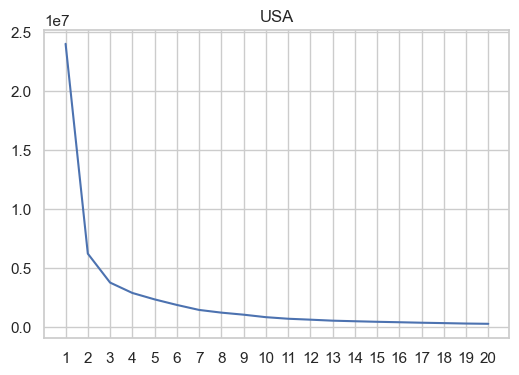

<Figure size 1600x900 with 0 Axes>

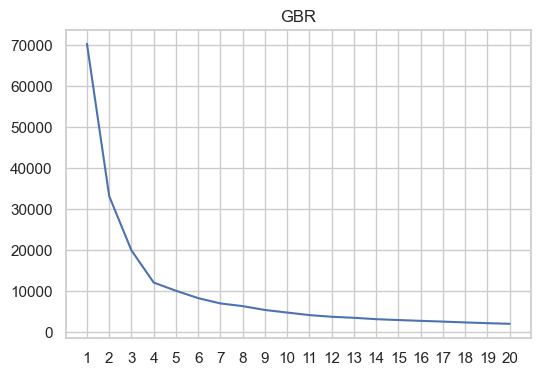

<Figure size 1600x900 with 0 Axes>

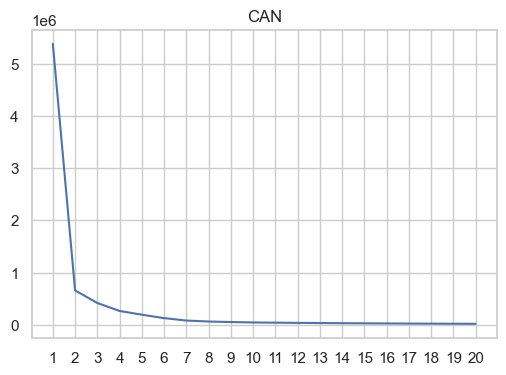

<Figure size 1600x900 with 0 Axes>

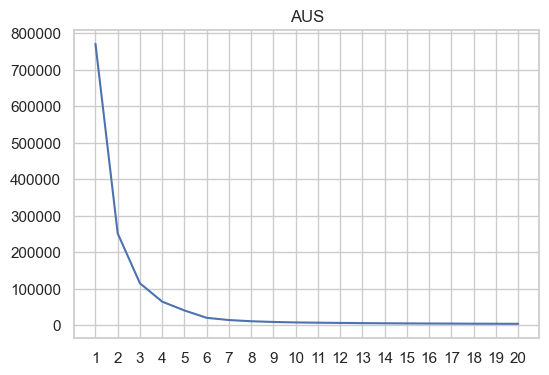

<Figure size 1600x900 with 0 Axes>

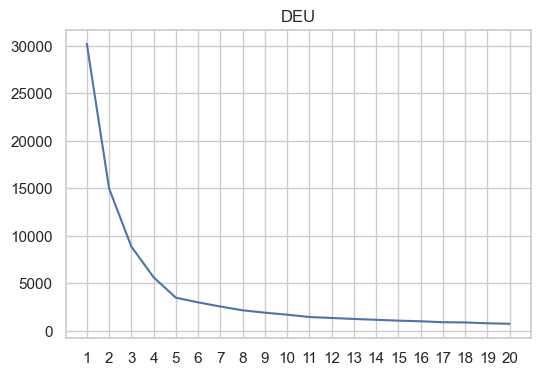

<Figure size 1600x900 with 0 Axes>

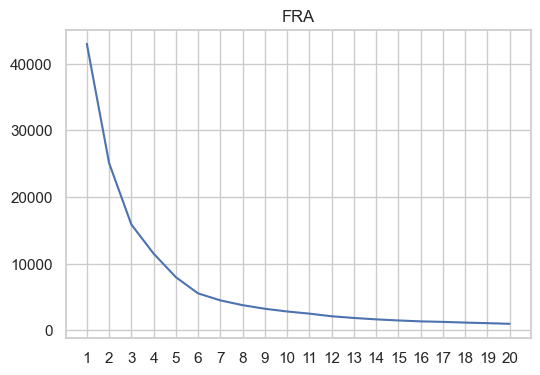

<Figure size 1600x900 with 0 Axes>

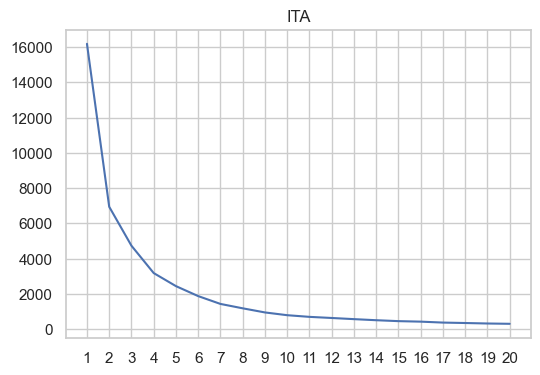

<Figure size 1600x900 with 0 Axes>

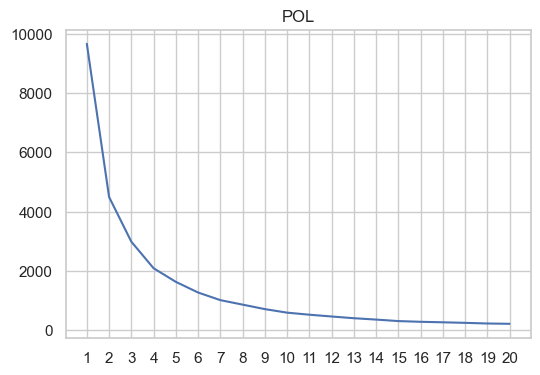

<Figure size 1600x900 with 0 Axes>

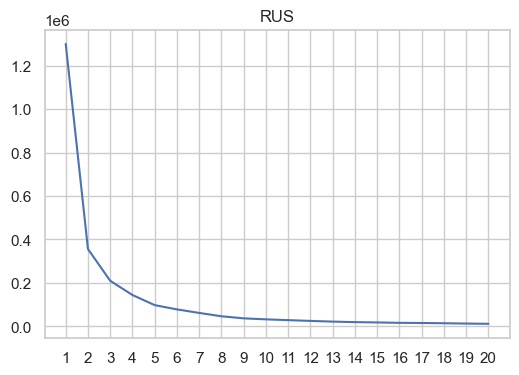

<Figure size 1600x900 with 0 Axes>

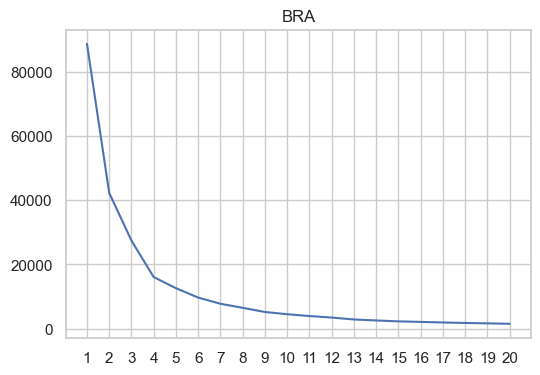

In [34]:
for i in top_countries.index:
    kmeans = [KMeans(n_clusters=j, n_init=10) for j in range(1,21)] # n_init=10 to avoid the error message
    for model in kmeans:
        model.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
    inertias = [model.inertia_ for model in kmeans]
    plt.figure()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1,21),inertias)
    plt.xticks(range(1,21))
    plt.title(i)
    plt.show();

Even though each country behaves very differently in the web, there's a maximum of 5-6 clusters for the top countries.

In [113]:
for i in countries:
    try:
        km = KMeans(n_clusters=6, n_init=10)
        km.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
        cluster_pred = km.predict(df_copy[["lat", "long"]])
        df_copy[i] = cluster_pred
    except:
        try:
            km = KMeans(n_clusters=5, n_init=10)
            km.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
            cluster_pred = km.predict(df_copy[["lat", "long"]])
            df_copy[i] = cluster_pred
        except:
            try:
                km = KMeans(n_clusters=4, n_init=10)
                km.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
                cluster_pred = km.predict(df_copy[["lat", "long"]])
                df_copy[i] = cluster_pred
            except:
                try:
                    km = KMeans(n_clusters=3, n_init=10)
                    km.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
                    cluster_pred = km.predict(df_copy[["lat", "long"]])
                    df_copy[i] = cluster_pred
                except:
                    try:
                        km = KMeans(n_clusters=2, n_init=10)
                        km.fit(df_copy[["lat", "long"]][df_copy["country_code"]==i])
                        cluster_pred = km.predict(df_copy[["lat", "long"]])
                        df_copy[i] = cluster_pred
                    except:
                        df_copy[i] = 0

In [114]:
df_copy

,lat,long,country_code,ARG,MOZ,KWT,KEN,UKR,GRC,BRA,FIN,PRK,KAZ,UZB,EGY,CAN,BWA,SOL,ROU,MYS,GAB,DNK,LVA,NCL,MNG,ECU,SWE,CZE,URY,ZMB,POL,NOR,NER,BDI,TUR,AZE,FLK,CYN,USA,BLR,PER,BTN,MEX,SAU,OMN,ARE,LBN,COL,SLV,FJI,LBR,ETH,PSE,TKM,QAT,HND,UGA,XXK,NIC,TUN,GMB,JAM,CYP,BEL,LTU,SEN,BGD,LAO,CHE,AGO,ISR,FRA,IDN,PAN,HUN,ZWE,GRL,YEM,MRT,BGR,MAR,AUT,SRB,LKA,PNG,PRY,IRN,BLZ,VNM,VEN,BIH,MLI,JOR,COG,HTI,CHN,PRT,NZL,THA,BEN,SOM,TLS,SLE,CAF,TJK,ATF,IND,MMR,LUX,ISL,SVN,NPL,CMR,KGZ,SSD,LBY,IRL,NLD,EST,PHL,MNE,ARM,CIV,BRN,ALB,MDG,TWN,SWZ,CUB,CHL,BOL,NaN,MKD,JPN,TGO,NAM,BHS,COD,TTO,TZA,IRQ,SYR,GHA,MWI,ATA,AFG,PAK,ZAF,RUS,MDA,AUS,GNB,SVK,DOM,PRI,NGA,ITA,BFA,CRI,ERI,GUY,SUR,DEU,GBR,KOR,GEO,HRV,TCD,DZA,GTM,KHM,ESP,cluster
0,45.524600,-73.604493,CAN,5,2,4,3,3,0,3,3,4,4,3,3,4,5,2,0,4,1,0,2,0,5,1,1,4,1,2,3,2,1,0,0,2,1,5,0,4,4,0,4,5,4,2,0,1,2,0,0,2,2,2,2,3,2,2,2,3,1,1,4,2,2,3,1,1,2,2,2,3,5,5,3,2,2,0,5,2,3,2,3,2,2,2,4,1,3,3,4,0,1,0,1,2,0,2,1,0,0,0,0,0,3,0,0,4,3,3,5,1,2,1,0,4,3,0,4,5,2,0,1,1,5,1,2,0,2,2,5,0,2,3,0,1,2,1,2,1,5,0,0,0,1,2,1,0,5,1,1,0,2,5,1,0,0,0,5,2,4,1,4,4,0,2,3,5,3,2,2,5,1.0
1,45.514617,-73.575139,CAN,5,2,4,3,3,0,3,3,4,4,3,3,4,5,2,0,4,1,0,2,0,5,1,1,4,1,2,3,2,1,0,0,2,1,5,0,4,4,0,4,5,4,2,0,1,2,0,0,2,2,2,2,3,2,2,2,3,1,1,4,2,2,3,1,1,2,2,2,3,5,5,3,2,2,0,5,2,3,2,3,2,2,2,4,1,3,3,4,0,1,0,1,2,0,2,1,0,0,0,0,0,3,0,0,4,3,3,5,1,2,1,0,4,3,0,4,5,2,0,1,1,5,1,2,0,2,2,5,0,2,3,0,1,2,1,2,1,5,0,0,0,1,2,1,0,5,1,1,0,2,5,1,0,0,0,5,2,4,1,4,4,0,2,3,5,3,2,2,5,1.0
2,45.525991,-73.603195,CAN,5,2,4,3,3,0,3,3,4,4,3,3,4,5,2,0,4,1,0,2,0,5,1,1,4,1,2,3,2,1,0,0,2,1,5,0,4,4,0,4,5,4,2,0,1,2,0,0,2,2,2,2,3,2,2,2,3,1,1,4,2,2,3,1,1,2,2,2,3,5,5,3,2,2,0,5,2,3,2,3,2,2,2,4,1,3,3,4,0,1,0,1,2,0,2,1,0,0,0,0,0,3,0,0,4,3,3,5,1,2,1,0,4,3,0,4,5,2,0,1,1,5,1,2,0,2,2,5,0,2,3,0,1,2,1,2,1,5,0,0,0,1,2,1,0,5,1,1,0,2,5,1,0,0,0,5,2,4,1,4,4,0,2,3,5,3,2,2,5,1.0
3,45.525713,-73.603528,CAN,5,2,4,3,3,0,3,3,4,4,3,3,4,5,2,0,4,1,0,2,0,5,1,1,4,1,2,3,2,1,0,0,2,1,5,0,4,4,0,4,5,4,2,0,1,2,0,0,2,2,2,2,3,2,2,2,3,1,1,4,2,2,3,1,1,2,2,2,3,5,5,3,2,2,0,5,2,3,2,3,2,2,2,4,1,3,3,4,0,1,0,1,2,0,2,1,0,0,0,0,0,3,0,0,4,3,3,5,1,2,1,0,4,3,0,4,5,2,0,1,1,5,1,2,0,2,2,5,0,2,3,0,1,2,1,2,1,5,0,0,0,1,2,1,0,5,1,1,0,2,5,1,0,0,0,5,2,4,1,4,4,0,2,3,5,3,2,2,5,1.0
4,45.460612,-73.504457,CAN,5,2,4,3,3,0,3,3,4,4,3,3,4,5,2,0,4,1,0,2,0,5,1,1,4,1,2,3,2,1,0,0,2,1,5,0,4,4,0,4,5,4,2,0,1,2,0,0,2,2,2,2,3,2,2,2,3,1,1,4,2,2,3,1,1,2,2,2,3,5,5,3,2,2,0,5,2,3,2,3,2,2,2,4,1,3,3,4,0,1,0,1,2,0,2,1,0,0,0,0,0,3,0,0,4,3,3,5,1,2,1,0,4,3,0,4,5,2,0,1,1,5,1,2,0,2,2,5,0,2,3,0,1,2,1,2,1,5,0,0,0,1,2,1,0,5,1,1,0,2,5,1,0,0,0,5,2,4,1,4,4,0,2,3,5,3,2,2,5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148710,39.474226,-0.371138,ESP,5,2,4,3,3,0,2,3,4,4,3,3,2,5,2,0,4,1,4,2,0,5,4,4,4,1,5,2,2,2,0,0,2,4,5,0,4,2,0,4,5,2,2,0,5,1,0,0,2,2,1,2,3,0,2,2,3,0,2,4,2,2,5,1,1,2,2,2,0,5,0,3,2,5,0,1,2,2,2,4,2,2,1,4,1,3,2,4,0,1,0,1,2,5,2,1,0,0,0,0,0,3,0,0,4,3,2,5,1,1,1,0,4,4,0,4,5,2,0,1,1,5,2,2,0,4,2,0,0,2,3,0,1,0,3,3,1,5,0,0,0,4,2,4,1,5,2,1,0,2,2,4,1,4,1,2,1,0,1,5,1,0,2,3,1,5,2,2,1,5.0
148711,39.214083,23.018151,GRC,5,1,4,3,3,2,2,1,4,4,3,3,2,5,2,1,4,1,1,1,0,5,4,4,5,1,5,5,3,2,0,0,2,4,5,0,4,2,0,4,5,2,2,2,5,1,0,0,2,4,1,2,3,0,3,2,5,0,2,4,0,3,5,1,1,3,2,5,1,5,0,5,5,5,0,1,0,2,3,0,2,2,1,4,1,3,2,2,0,3,0,1,2,5,1,1,0,1,0,0,0,3,0,0,0,4,2,4,1,1,1,0,0,0,2,2,5,5,0,1,1,2,5,2,0,4,2,0,0,3,3,0,1,0,2,3,1,5,2,0,0,4,2,4,1,1,4,1,0,1,2,4,1,3,1,2,1,0,1,3,1,0,2,4,1,0,2,2,3,4.0
148712

In [115]:
for i in countries:
    for j in df_copy.columns:
        if i == j:
            df_copy.loc[df_copy[df_copy["country_code"]==i].index, "cluster"] = df_copy[i]   

In [118]:
df["cluster"] = df_copy["cluster"]

In [119]:
df.to_csv("../data/total_df.csv")

In [120]:
df_copy.to_csv("../data/clusters.csv")

**Entities try:**

For most of the countries it cannot be done for the ammount of characters. I used en_core_web_md and en_core_web_sm, en_core_web_lg couldn't be download in my computer.

I have done different tries with different countries.

**These entities aren't right**

In [16]:
# There are many empty rows, fill with min (some of them are regions, when merged these rows will disappear)
# child["mean_child_noSchool"].loc[child[child["mean_child_noSchool"].isna()].index] = child["mean_child_noSchool"].max()